### deepxde学习
deepxde的一般套路：  
（1）数据：包括边界，pde方程，定义域，若有解析解可用于检测测试误差  
（2）神经网络：包括每一层的神经元的数量，激活函数，以及神经网络的初始化  
（3）用数据和神经网络构建模型，然后编译

#### 简单ODE方程  
考虑如下简单的ODE方程：  
$$
\frac{dy_1}{dt}=y_2\\
\frac{dy_2}{dt}=y_1
$$
其中$t\in [0,10]$, 边界条件为$y_1(0)=0,y_2(0)=1$, 实际解为$y_1=sint,y_2=cost$

首先导入我们需要的deepxde库和numpy库

In [1]:
import deepxde as dde
import numpy as np

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



创建computational geometry，其中设置了time domain(也即t的取值范围)

In [2]:
geom=dde.geometry.TimeDomain(0,10)

接下来我们定义ODE方程，输入的第一个参数为神经网络的输入，也即我们要求的t，第二个参数为神经网络的输出，也即y，其中y[:,0:1]表示$y_1$，y[:,1:]表示$y_2$，将我们已有的方程的右边均移项移至左边，得到的方程组为输出。

In [3]:
def ode_system(x,y):
    y1,y2=y[:,0:1],y[:,1:]
    dy1_x=dde.grad.jacobian(y1,x)#定义y_1的导数
    dy2_x=dde.grad.jacobian(y2,x)#定义y_2的导数
    return [dy1_x-y2,dy2_x+y1]

接下来定义边界条件

In [4]:
def boundary(x,on_initial):
    return np.isclose(x[0],0)#即x[0][i]=0时为true,否则为false

"""
由于起始点即为t=0,所以我们也可以有如下定义方式
def boundary(_,on_initial):
    return on_initial
"""

#边界定义,第二个参数为边界值，component为标志该边界是第一个component还是第二个
ic1=dde.icbc.IC(geom,lambda x:0,boundary,component=0)
ic2=dde.icbc.IC(geom,lambda x:1,boundary,component=1)

接下来定义真实解函数，即
$$
y_1=sint\\
y_2=cost
$$

In [5]:
def func(x):
    return np.hstack((np.sin(x),np.cos(x)))

接下来定义该ODE问题，采用PDE求解器

In [6]:
data=dde.data.PDE(geom,ode_system,[ic1,ic2],35,2,solution=func,num_test=100)
#其中35为定义域上的采样的点的个数，2是边界点个数(即左边界和右边界)，100为测试点的个数

c:\Users\10161\anaconda3\envs\my_python_env\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+37=37. 
  warnings.warn("The balance properties of Sobol' points require "


接下来定义神经网络，我们采用四层（即三隐藏层）的网络，其中每个隐藏层有50个神经元，而输入输出分别为1和2，激活函数用tanh，初始化采用"Glorot uniform"，

In [7]:
layer_size=[1]+[50]*3+[2]
activation='tanh'
initializer='Glorot uniform'
net=dde.nn.FNN(layer_size,activation,initializer)

现在就可以实例化模型并进行训练，我们迭代两万次

In [8]:
model=dde.Model(data,net)
model.compile("adam",lr=0.001, metrics=["l2 relative error"])
losshistory,train_state=model.train(iterations=20000)

Compiling model...
Building feed-forward neural network...
'build' took 0.071521 s



c:\Users\10161\anaconda3\envs\my_python_env\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.340710 s

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [2.13e-02, 1.70e-01, 0.00e+00, 1.00e+00]    [2.01e-02, 1.75e-01, 0.00e+00, 1.00e+00]    [1.14e+00]    
1000      [8.50e-03, 7.27e-03, 2.01e-07, 3.07e-04]    [9.35e-03, 6.77e-03, 2.01e-07, 3.07e-04]    [7.74e-01]    
2000      [5.89e-03, 4.56e-03, 8.09e-07, 1.33e-04]    [6.24e-03, 4.41e-03, 8.09e-07, 1.33e-04]    [6.18e-01]    
3000      [3.54e-03, 3.35e-03, 1.34e-06, 6.71e-05]    [4.01e-03, 3.25e-03, 1.34e-06, 6.71e-05]    [4.84e-01]    
4000      [1.59e-03, 2.13e-03, 1.08e-05, 1.14e-04]    [1.78e-03, 2.01e-03, 1.08e-05, 1.14e-04]    [3.26e-01]    
5000      [4.53e-04, 6.51e-04, 1.61e-07, 7.15e-06]    [5.43e-04, 6.01e-04, 1.61e-07, 7.15e-06]    [1.66e-01]    
6000      [1.99e-04, 1.64e-04, 8.99e-08, 1.41e-06]    [2.25e-04, 1.76e-04, 8.99e-08, 1.41e-06]    [8.06e-02]    
7000      [1.18e-04, 6.8

显示迭代误差与预测结果

Saving loss history to d:\study\code\py\pde\loss.dat ...
Saving training data to d:\study\code\py\pde\train.dat ...
Saving test data to d:\study\code\py\pde\test.dat ...


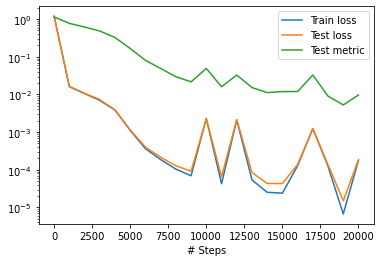

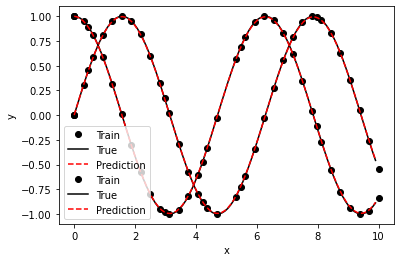

In [9]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

对于实际数据可以采用predict函数进行预测，输入为np.array数组，输出预测结果

In [11]:
print(model.predict(np.array([np.pi/2,np.pi]).reshape(-1,1)))

[[ 1.0004866e+00  9.6410140e-04]
 [ 1.0867678e-03 -1.0000387e+00]]


没有解析解也可以将func省去，代码如下

In [12]:
data=dde.data.PDE(geom,ode_system,[ic1,ic2],35,2,num_test=100)
model=dde.Model(data,net)
model.compile("adam",lr=0.001)
model.train(iterations=20000)

Compiling model...
'compile' took 0.336380 s

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [4.63e-02, 2.11e-01, 0.00e+00, 1.00e+00]    [4.27e-02, 2.17e-01, 0.00e+00, 1.00e+00]    []  
1000      [9.00e-03, 7.46e-03, 2.05e-08, 3.52e-04]    [1.00e-02, 6.90e-03, 2.05e-08, 3.52e-04]    []  
2000      [5.84e-03, 4.59e-03, 5.64e-07, 1.45e-04]    [6.22e-03, 4.43e-03, 5.64e-07, 1.45e-04]    []  
3000      [3.53e-03, 3.29e-03, 7.84e-07, 6.75e-05]    [3.93e-03, 3.18e-03, 7.84e-07, 6.75e-05]    []  
4000      [1.57e-03, 2.12e-03, 1.12e-06, 2.76e-05]    [1.79e-03, 1.90e-03, 1.12e-06, 2.76e-05]    []  
5000      [6.97e-04, 9.02e-04, 3.01e-07, 1.18e-05]    [7.74e-04, 7.17e-04, 3.01e-07, 1.18e-05]    []  
6000      [4.06e-04, 5.22e-04, 3.93e-06, 3.49e-05]    [4.05e-04, 3.70e-04, 3.93e-06, 3.49e-05]    []  
7000      [1.79e-03, 5.66e-04, 1.29e-04, 1.87e-04]    [1.76e-03, 4.11e-04, 1.2

(<deepxde.model.LossHistory at 0x1fd6f6f48e0>,
 <deepxde.model.TrainState at 0x1fd72967a00>)

#### 简单PDE

考虑1维possion方程：
$$
\Delta u=2,x\in [-1,1]
$$
右边界为Neumman边界条件，即
$$
\frac{du}{dx}|_{x=1}=4
$$
左边界为Dirichlet边界条件，即
$$
u(-1)=0
$$
实际解为
$$
u(x)=(x+1)^2
$$
（与上面重复的部分只给出代码，不解释）

首先导入所需要的库：

In [3]:
import deepxde as dde
import numpy as np

接下来定义pde system，边界条件，以及实际解，并构建数据集。

In [17]:
def pde(x,y):
    dy_xx=dde.grad.hessian(y,x)
    return dy_xx-2

def func(x):
    return (x+1)**2

#左边界
def boundary_l(x,on_boundary):
    return on_boundary and np.isclose(x[0],-1)

#右边界
def boundary_r(x,on_boundary):
    return on_boundary and np.isclose(x[0],1)

#定义域
geom=dde.geometry.Interval(-1,1)

#Dirichlet边界条件
bc_l=dde.icbc.DirichletBC(geom,func,boundary_l)

#Neumann边界条件
bc_r=dde.icbc.NeumannBC(geom,lambda X:2*(X+1),boundary_r)

data=dde.data.PDE(geom,pde,[bc_l,bc_r],16,2,solution=func,num_test=100)

接下来定义神经网络

In [19]:
layer_size=[1]+[50]*3+[1]
activation='tanh'
initializer="Glorot uniform"
net=dde.nn.FNN(layer_size,activation,initializer)

神经网络求解

In [21]:
model = dde.Model(data, net)#注意先数据后网络
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=10000)

Compiling model...
Building feed-forward neural network...
'build' took 0.034966 s

'compile' took 0.271964 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [4.00e+00, 3.99e-02, 1.44e+01]    [4.00e+00, 3.99e-02, 1.44e+01]    [9.60e-01]    
1000      [1.66e-03, 4.30e-08, 6.44e-07]    [1.13e-03, 4.30e-08, 6.44e-07]    [1.44e-03]    
2000      [1.58e-04, 3.95e-08, 6.56e-08]    [8.24e-05, 3.95e-08, 6.56e-08]    [5.85e-04]    
3000      [5.43e-05, 9.11e-10, 3.67e-09]    [3.99e-05, 9.11e-10, 3.67e-09]    [8.58e-04]    
4000      [3.59e-05, 2.57e-07, 1.02e-07]    [2.97e-05, 2.57e-07, 1.02e-07]    [7.47e-04]    
5000      [2.81e-05, 6.69e-09, 7.87e-07]    [2.06e-05, 6.69e-09, 7.87e-07]    [6.33e-04]    
6000      [1.85e-05, 5.72e-10, 7.39e-10]    [1.70e-05, 5.72e-10, 7.39e-10]    [5.58e-04]    
7000      [1.41e-05, 1.15e-06, 3.44e-07]    [1.35e-05, 1.15e-06, 3.44e-07]    [4.64e-04]    
8000   

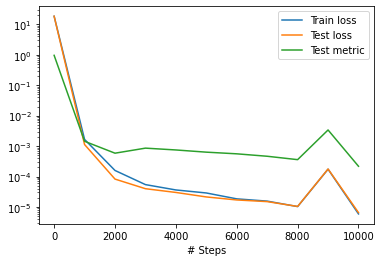

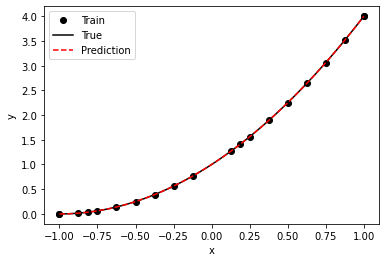

In [22]:
dde.saveplot(losshistory, train_state,issave=False,isplot=True)

####  2维PDE

考虑Helmholtz equation。形式如下：  
$$- u_{xx}-u_{yy} - k_0^2 u = f, \qquad \Omega = [0,1]^2$$
考虑Dirichlet边界条件：  
$$ u(x, y) = 0,\ (x, y) \in \partial \Omega$$
令$$f(x,y) = k_0^2\sin(k_0 x)\sin(k_0 y)$$
其真实解为$$u(x,y)= \sin(k_0 x)\sin(k_0 y)$$
dde求解过程如下

In [20]:
import deepxde as dde
import numpy as np

定义模型超参数

In [21]:
iterations=5000
parameters=[1e-3,3,150,'sin']

if dde.backend.backend_name=='pytorch':
    sin=dde.backend.pytorch.sin
else:
    sin=dde.backend.tf.sin

learning_rate,num_dense_layers,num_dense_nodes,activation=parameters

接下来定义pde system，其中输入x为自变量，即[x;y]，u为因变量

In [22]:
def pde(x,u):
    du_xx=dde.grad.hessian(u,x,i=0,j=0) #i=0,j=0表示对x求两阶导
    du_yy=dde.grad.hessian(u,x,i=1,j=1) #i=1,j=1表示对y求两阶导

    f=k0**2*sin(k0*x[:,0:1])*sin(k0*x[:,1:2])
    return -du_xx-du_yy-k0**2*u-f

接下来定义该PDE的真实解与边界

In [23]:
def func(x):
    return np.sin(k0*x[:,0:1])*np.sin(k0*x[:,1:2])


def boundary(_,on_boundary):
    return on_boundary

接下来定义geometry，周期长度等参数

In [24]:
geom=dde.geometry.Rectangle([0,0],[1,1]) #定义域[0,1]x[0,1]

n=2 #[0,1]内的周期数
k0=2*np.pi*n 
wave_len=1/n #周期

precision_train=10 #一个周期内训练集的点的个数
precision_test=30 #一个周期内测试集点的个数
hard_constraint=True #True为hard boundary conditions，即边界误差的比重与内部误差比重相同
weight=100 #soft boundary conditions 条件下，内部误差比重为100，边界为1

hx_train=wave_len/precision_train
nx_train=int(1/hx_train) #训练点的总个数

hx_test=wave_len/precision_test
nx_test=int(1/hx_test) #测试点的总个数

if hard_constraint==True:
    bc=[]
else:
    bc=dde.icbc.DirichletBC(geom,lambda x:0,boundary)

接下来定义数据与神经网络

In [25]:
data=dde.data.PDE(
    geom,
    pde,
    bc,
    num_domain=nx_train**2, #相当于每个方向都去nx_train个
    num_boundary=4*nx_train, #四条边
    solution=func,
    num_test=nx_test**2,
)

net=dde.nn.FNN([2]+[num_dense_nodes]*num_dense_layers+[1],activation,"Glorot uniform")

c:\Users\10161\anaconda3\envs\my_python_env\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+402=402. 
  warnings.warn("The balance properties of Sobol' points require "
c:\Users\10161\anaconda3\envs\my_python_env\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+84=84. 
  warnings.warn("The balance properties of Sobol' points require "


在hard constraint的条件下，我们可以通过如下transform来增强boundary conditions:
$$
\widehat{u}(x,y)=x(x−1)y(y−1)\mathcal{N}(x,y)
$$

In [26]:
def transform(x,y):
    res=x[:,0:1]*(1-x[:,0:1])*x[:,1:2]*(1-x[:,1:2])
    return res*y

if hard_constraint==True:
    net.apply_output_transform(transform)

接下来使用model进行求解

In [27]:
model=dde.Model(data,net)

if hard_constraint:
    model.compile("adam",lr=learning_rate,metrics=["l2 relative error"])
else:
    loss_weights=[1,weight]
    model.compile(
        "adam",
        lr=learning_rate,
        metrics=["l2 relative error"],
        loss_weights=loss_weights,
    )
losshistory,train_state=model.train(iterations=iterations)

Compiling model...
Building feed-forward neural network...
'build' took 0.062645 s



c:\Users\10161\anaconda3\envs\my_python_env\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.150856 s

Initializing variables...
Training model...

Step      Train loss    Test loss     Test metric   
0         [5.47e+03]    [6.44e+03]    [1.00e+00]    
1000      [7.10e+01]    [8.65e+01]    [3.78e-01]    
2000      [1.15e+01]    [1.46e+01]    [1.48e-01]    
3000      [1.42e+00]    [1.98e+00]    [4.85e-02]    
4000      [2.07e-01]    [3.26e-01]    [1.64e-02]    
5000      [7.98e-02]    [1.23e-01]    [8.38e-03]    

Best model at step 5000:
  train loss: 7.98e-02
  test loss: 1.23e-01
  test metric: [8.38e-03]

'train' took 102.324616 s



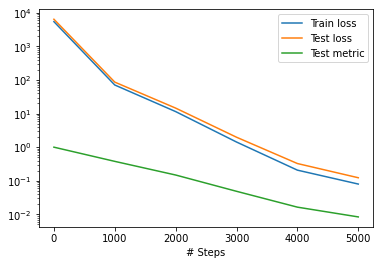

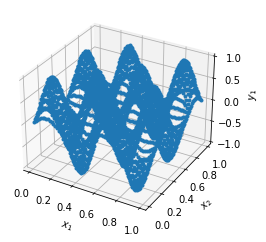

In [28]:
dde.saveplot(losshistory,train_state,issave=False,isplot=True)

#### 算子学习

我们以学习积分算子为例，具体问题如下：  
需要学习的算子$$G:v\mapsto u$$满足ODE方程$$\frac{du(x)}{dx}=v(x),x\in [0,1],$$
边界条件为$u(0)=0$  
我们有的训练数据集为$(x_i,u(x_i))$(在该例子中有150个，每个u有100个x)以及与之相对应的函数$G(u)$，函数G(u)的输入为y，用一串$G(u)(y)$的值来表示$G(u)$，在该例子中，y的取值与x取值相同。
训练数据集为"antiderivative_aligned_train.npz"，测试数据集为"antiderivative_aligned_test.npz"

首先导入所需的库

In [2]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



接下来导入数据集。该网络中的一个数据点为一对$(v,u)$(在该数据集中我们有50个这样的函数对)。我们通过如下方法生成：  
1.函数$v$在Gaussian random field (GRF) 上随机取点（这里取m=100个点）  
2.通过数值算法求解$u$。对于每个$u$，我们有100个u(x)的值，且每个$u$所取的x相同，也即我们有$N_u=100$个x。

In [3]:
d=np.load("antiderivative_aligned_train.npz",allow_pickle=True)
X_train=(d["X"][0].astype(np.float32),d["X"][1].astype(np.float32))
y_train=d["y"].astype(np.float32)
print(X_train[0].shape,X_train[1].shape,y_train.shape)
d=np.load("antiderivative_aligned_test.npz",allow_pickle=True)
X_test=(d["X"][0].astype(np.float32),d["X"][1].astype(np.float32))
y_test=d["y"].astype(np.float32)
print(X_test[0].shape,X_test[1].shape,y_test.shape)

(150, 100) (100, 1) (150, 100)
(1000, 100) (100, 1) (1000, 100)


接下来定义所需数据

In [4]:
data=dde.data.TripleCartesianProd(
    X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test
)

接下来定义神经网络DeepONet
由于输入数据包括$(x_i,u(x_i)$与$y$, 其中$y\in\mathbb{R}^d$, $u(x_i)\in \mathbb{R}$, 所以我们需要两个前馈神经网络(FNN)来分别处理$(x_i,u(x_i)$与$y$. 首先我们有“trunk net”, 以y为输入, $[t_1,\dots,t_p]$为输出. 除此之外我们有“branch net”, 以$(x_i,u(x_i)_{i=1}^{m}$为输入, 以$[b_1,\dots,b_p]$为输出, 然后我们把这两个网络乘起来, 得到
$$
G(u)(y)\approx \sum\limits_{k=1}^{p}\underbrace{b_k(u(x_1),\dots,u(x_m))}_{branch}\underbrace{t_k(y)}_{trunk}
$$
<div align=center><img src="5.png"></div>

In [5]:
m=100
dim_x=1
net=dde.nn.DeepONetCartesianProd(
    [m,40,40], #branch net
    [dim_x,40,40], #trunk net
    'tanh',
    'Glorot normal',
)

接下来为训练过程

In [6]:
model=dde.Model(data,net)
model.compile("adam",lr=0.001,metrics=["mean l2 relative error"])
losshistory,train_state=model.train(iterations=10000)

Compiling model...
Building DeepONetCartesianProd...
'build' took 0.046769 s

'compile' took 0.150269 s

Initializing variables...


c:\Users\10161\anaconda3\envs\my_python_env\lib\site-packages\deepxde\nn\tensorflow_compat_v1\deeponet.py:312: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  y_func = tf.layers.dense(
c:\Users\10161\anaconda3\envs\my_python_env\lib\site-packages\deepxde\nn\tensorflow_compat_v1\deeponet.py:319: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  y_func = tf.layers.dense(
c:\Users\10161\anaconda3\envs\my_python_env\lib\site-packages\deepxde\nn\tensorflow_compat_v1\deeponet.py:331: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  y_loc = tf.layers.dense(


Training model...

Step      Train loss    Test loss     Test metric   
0         [6.33e-02]    [6.49e-02]    [5.23e-01]    
1000      [3.76e-04]    [6.11e-04]    [7.03e-02]    
2000      [3.33e-04]    [4.99e-04]    [6.50e-02]    
3000      [5.51e-04]    [6.43e-04]    [7.17e-02]    
4000      [2.97e-04]    [4.13e-04]    [6.07e-02]    
5000      [2.46e-04]    [3.41e-04]    [5.52e-02]    
6000      [8.42e-04]    [1.04e-03]    [6.46e-02]    
7000      [3.80e-05]    [1.25e-04]    [2.50e-02]    
8000      [6.40e-05]    [1.73e-04]    [2.79e-02]    
9000      [3.64e-05]    [1.23e-04]    [2.42e-02]    
10000     [3.01e-05]    [1.15e-04]    [2.33e-02]    

Best model at step 10000:
  train loss: 3.01e-05
  test loss: 1.15e-04
  test metric: [2.33e-02]

'train' took 4.788503 s



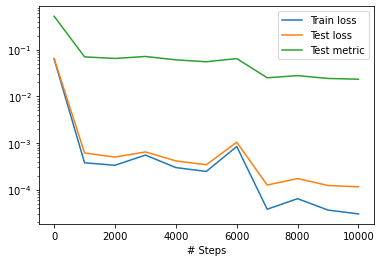

In [7]:
dde.utils.plot_loss_history(losshistory)
plt.show()

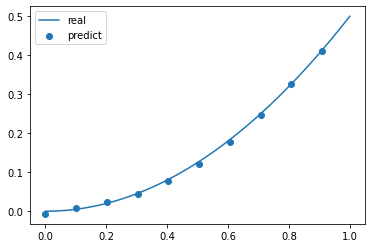

In [13]:
x=X_train[1].reshape(1,100)
y=X_train[1].copy()
result=model.predict((x,y))
plt.plot(x.reshape(100),0.5*x.reshape(100)**2,label='real')
plt.scatter(x.reshape(100)[::10],result.reshape(100)[::10],label='predict')
plt.legend(loc='best')
plt.show()